<a href="https://colab.research.google.com/github/hyunwookim129/Resnet_Pneu_Grad/blob/main/ResNet_pneua_GradCAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Path to dataset files:", path)

100%|██████████| 2.29G/2.29G [00:36<00:00, 66.6MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2


In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pathlib
from pathlib import Path
import shutil

# For computing class weights
from sklearn.utils.class_weight import compute_class_weight

# TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50

In [ ]:
# For Google Drive mounting (if using Colab)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Define dataset directories
train_image_path = pathlib.Path('/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/train')
val_image_path   = pathlib.Path('/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/val')
test_image_path  = pathlib.Path('/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/test')

print("\n=== Checking training folder structure ===")
train_classes = os.listdir(train_image_path)
print("Classes in train folder:", train_classes)

normal_images     = os.listdir(train_image_path / "NORMAL")
pneumonia_images  = os.listdir(train_image_path / "PNEUMONIA")
num_normal_images = len(normal_images)
num_pneumonia_img = len(pneumonia_images)
print(f"Number of NORMAL images:    {num_normal_images}")
print(f"Number of PNEUMONIA images: {num_pneumonia_img}")

print("\n=== Merging original 'val' folder into 'train', then re-splitting ===")
for folder in ['NORMAL', 'PNEUMONIA']:
    val_folder   = val_image_path / folder
    train_folder = train_image_path / folder
    for img_file in os.listdir(val_folder):
        shutil.move(str(val_folder / img_file), str(train_folder))

# Now we re-split the combined train data into new train & validation sets
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # 20% for validation
)
test_datagen = ImageDataGenerator(rescale=1./255)


batch_size = 16
img_size   = (150, 150)

train_generator = train_datagen.flow_from_directory(
    train_image_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='training'
)
val_generator = train_datagen.flow_from_directory(
    train_image_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)
test_generator = test_datagen.flow_from_directory(
    test_image_path,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

print(f"Training samples:   {train_generator.samples}")
print(f"Validation samples: {val_generator.samples}")

# Check class distribution in train/val
train_labels = train_generator.labels
val_labels   = val_generator.labels
train_bincnt = np.bincount(train_labels)
val_bincnt   = np.bincount(val_labels)
class_names  = list(train_generator.class_indices.keys())

for i, cls_name in enumerate(class_names):
    print(f"Train - {cls_name}: {train_bincnt[i]}")
    print(f"Val   - {cls_name}: {val_bincnt[i]}")


print("\n=== Computing class weights ===")
cw_values = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights_dict = dict(enumerate(cw_values))
print("Class Weights:", class_weights_dict)


=== Checking training folder structure ===
Classes in train folder: ['NORMAL', 'PNEUMONIA']
Number of NORMAL images:    1341
Number of PNEUMONIA images: 3875

=== Merging original 'val' folder into 'train', then re-splitting ===
Found 4187 images belonging to 2 classes.
Found 1045 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Training samples:   4187
Validation samples: 1045
Train - NORMAL: 1080
Val   - NORMAL: 269
Train - PNEUMONIA: 3107
Val   - PNEUMONIA: 776

=== Computing class weights ===
Class Weights: {0: 1.938425925925926, 1: 0.6738010943031864}


In [ ]:
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(150, 150, 3)
)

# Custom Fully Connected Layers
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output_tensor = Dense(1, activation='sigmoid')(x)  # Apply Dense layer to previous output

# Define Final Model
model = Model(inputs=base_model.input, outputs=output_tensor)  # Use the output tensor

# Compile Model
optimizer = Adam(learning_rate=0.0001)
model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Model Summary
model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 150, 150, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 156, 156, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 75, 75, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 75, 75, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 75, 75, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 77, 77, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 38, 38, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 38, 38, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 38, 38, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 38, 38, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 38, 38, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 38, 38, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 38, 38, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 38, 38, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 38, 38, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 23,850,113 (90.98 MB)

 Trainable params: 23,796,993 (90.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [ ]:
# Define Callbacks
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1),
    ModelCheckpoint('best_resnet50_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
]

# Train Model with Class Weights
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    class_weight=class_weights_dict,
    callbacks=callbacks
)

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step - accuracy: 0.8789 - loss: 0.2876
Epoch 1: val_loss improved from inf to 1.35228, saving model to best_resnet50_model.keras
262/262 ━━━━━━━━━━━━━━━━━━━━ 191s 448ms/step - accuracy: 0.8790 - loss: 0.2873 - val_accuracy: 0.2574 - val_loss: 1.3523 - learning_rate: 1.0000e-04
Epoch 2/30
262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - accuracy: 0.9418 - loss: 0.1400
Epoch 2: val_loss improved from 1.35228 to 0.72876, saving model to best_resnet50_model.keras
262/262 ━━━━━━━━━━━━━━━━━━━━ 135s 305ms/step - accuracy: 0.9419 - loss: 0.1400 - val_accuracy: 0.7426 - val_loss: 0.7288 - learning_rate: 1.0000e-04
Epoch 3/30
262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - accuracy: 0.9507 - loss: 0.1153
Epoch 3: val_loss did not improve from 0.72876
262/262 ━━━━━━━━━━━━━━━━━━━━ 87s 322ms/step - accuracy: 0.9507 - loss: 0.1153 - val_accuracy: 0.7426 - val_loss: 0.8709 - learning_rate: 1.0000e-04
Epoch 4/30
262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - accuracy: 0.95

In [ ]:
# # Save the trained model
# model.save("/content/drive/My Drive/ResNet_pneu_model.keras")
# model.save("/content/drive/My Drive/ResNet_pneu_model.h5")

# Load the model for Grad-CAM
loaded_model = tf.keras.models.load_model("/content/drive/My Drive/ResNet_pneu_model.keras")

print("✅ Model saved and loaded successfully!")

✅ Model saved and loaded successfully!


In [ ]:
last_conv_layer_name = "conv5_block3_out"

def make_gradcam_heatmap(img_array, model, last_conv_layer_name=last_conv_layer_name, pred_index=None):
    """
    ✅ Generates a Grad-CAM heatmap from a given model and image tensor.
    """

    # ✅ Grad-CAM 모델 생성 (마지막 Conv Layer + 최종 출력)
    grad_model = tf.keras.models.Model(
        inputs=model.input,
        outputs=[
            model.get_layer(last_conv_layer_name).output,  # 마지막 Conv Layer의 Feature Map
            model.output  # 모델 예측값
        ]
    )

    # ✅ Gradient Tape를 사용하여 Backpropagation 추적
    with tf.GradientTape() as tape:
        conv_outputs, preds = grad_model(img_array)  # Conv Layer 활성화 맵, 모델 예측값
        if pred_index is None:
            pred_index = tf.argmax(preds[0]) if preds.shape[-1] > 1 else 0  # 이진 분류일 경우 index=0

        # ✅ 선택한 클래스의 예측 확률을 기반으로 Gradient 계산
        class_channel = preds[:, pred_index]

    # ✅ Conv Layer에 대한 Gradient 계산
    grads = tape.gradient(class_channel, conv_outputs)
    if grads is None:
        raise ValueError(f"Gradients are None. Check that layer '{last_conv_layer_name}' is valid for backprop.")

    # ✅ Global Average Pooling (H, W 축에 대해 평균 내기)
    pooled_grads = tf.reduce_mean(grads, axis=(1, 2))

    # ✅ Feature Map에 대한 중요도 적용
    conv_outputs = conv_outputs[0].numpy()  # (H, W, C)
    pooled_grads = pooled_grads[0].numpy()  # (C,)

    for i in range(pooled_grads.shape[-1]):
        conv_outputs[:, :, i] *= pooled_grads[i]

    # ✅ Feature Map 합산 및 ReLU 적용
    heatmap = np.sum(conv_outputs, axis=-1)
    heatmap = np.maximum(heatmap, 0)

    # ✅ Normalize the heatmap to [0, 1]
    max_val = heatmap.max() if heatmap.max() != 0 else 1e-8
    heatmap /= max_val

    # ✅ Convert to 8-bit
    heatmap = np.uint8(255 * heatmap)
    return heatmap

def filter_high_importance(heatmap, threshold=0.8, alpha=5.0, beta=80):
    """
    ✅ Grad-CAM Heatmap에서 중요도가 낮은 부분을 제거하고,
       빨간색/노란색을 강조하며 밝기를 조정하는 함수.
       + alpha, beta 값을 조절하여 대비와 밝기를 더욱 세밀하게 조정
       + cv2.COLORMAP_TURBO 사용으로 빨간색과 노란색 계열 강조
    """
    heatmap = heatmap.astype(np.float32) / 255.0

    # ✅ Threshold 이하의 값 제거 (활성도가 약한 영역 제거)
    heatmap[heatmap < threshold] = 0.0

    # ✅ 남은 영역을 0~1로 다시 정규화하여 강조 (최대값으로 나누기)
    if heatmap.max() > 0:  # 0으로 나누는 에러 방지
        heatmap = heatmap / heatmap.max()

    heatmap = (heatmap * 255).astype(np.uint8)

    # ✅ 밝기 조정 (alpha=대비 증가, beta=밝기 증가)
    #   - alpha 값을 높이면 대비가 강해져 활성화된 영역이 더 뚜렷해짐
    #   - beta 값을 높이면 전반적인 밝기가 증가
    heatmap = cv2.convertScaleAbs(heatmap, alpha=alpha, beta=beta)

    # ✅ 컬러맵 적용 (빨간색/노란색 강조)
    filtered_heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_HOT)

    return filtered_heatmap

def overlay_highlighted_gradcam(original_img, heatmap, threshold=0.5, alpha=0.4):
    """
    ✅ 중요도가 높은 부분만 강조하고 원본 이미지는 유지하는 Grad-CAM Overlay.
    ✅ 원본 이미지는 그대로 두고, 활성화된 영역만 강조.
    ✅ 초록색 문제 해결: 컬러맵을 `COLORMAP_HOT`으로 변경.
    """

    # ✅ Heatmap을 원본 이미지 크기로 변환
    heatmap = cv2.resize(heatmap, (original_img.shape[1], original_img.shape[0]), interpolation=cv2.INTER_LINEAR)

    # ✅ 특정 Threshold 이하의 값 제거 (배경을 유지하기 위한 마스킹)
    heatmap = heatmap.astype(np.float32) / 255.0
    heatmap[heatmap < threshold] = 0.0

    # ✅ 남은 영역을 다시 정규화 (0~1) 후 255 스케일 변환
    if heatmap.max() > 0:
        heatmap = heatmap / heatmap.max()

    heatmap = (heatmap * 255).astype(np.uint8)

    # ✅ 초록색 문제 해결: 컬러맵을 `COLORMAP_HOT` 사용
    colored_heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_HOT)

    # ✅ 활성화된 영역만 원본 이미지 위에 Overlay (배경은 그대로 유지)
    highlighted_img = original_img.copy()

    # ✅ 중요한 영역만 마스크 적용
    mask = heatmap > (threshold * 255)

    # ✅ 마스크된 부분에만 컬러맵을 적용하여 Overlay
    highlighted_img[mask] = cv2.addWeighted(
        highlighted_img.astype(np.uint8), 1 - alpha, colored_heatmap, alpha, 0
    )[mask]

    return highlighted_img


In [ ]:
# Define test image directory (PNEUMONIA folder)
test_pneumonia_dir = Path('/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/test/PNEUMONIA')

# Verify if directory exists
if not test_pneumonia_dir.exists():
    raise ValueError(f"❌ ERROR: Test image folder not found at {test_pneumonia_dir}")

# Get a list of all images in the folder (JPEG, JPG, PNG)
image_files = list(test_pneumonia_dir.glob("*.jpeg")) + list(test_pneumonia_dir.glob("*.jpg")) + list(test_pneumonia_dir.glob("*.png"))

# Check if there are any images
if not image_files:
    raise ValueError(f"❌ ERROR: No images found in {test_pneumonia_dir}")

# Select the first image
test_image1_path = str(image_files[25])
print(f"Using test image: {test_image1_path}")
# Load the selected image

original_img = cv2.imread(test_image1_path)

# Ensure OpenCV successfully loads the image
if original_img is None:
    raise ValueError(f"❌ ERROR: Could not load image at {test_image1_path}. Check if the file exists!")

# Convert BGR to RGB (Matplotlib expects RGB)
original_img_rgb = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

# Resize image to model input size (150x150)
resized_img = cv2.resize(original_img_rgb, (150, 150))

# Prepare for model input (Normalize & Add batch dimension)
input_tensor = np.expand_dims(resized_img, axis=0) / 255.0

Using test image: /root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/test/PNEUMONIA/person103_bacteria_490.jpeg


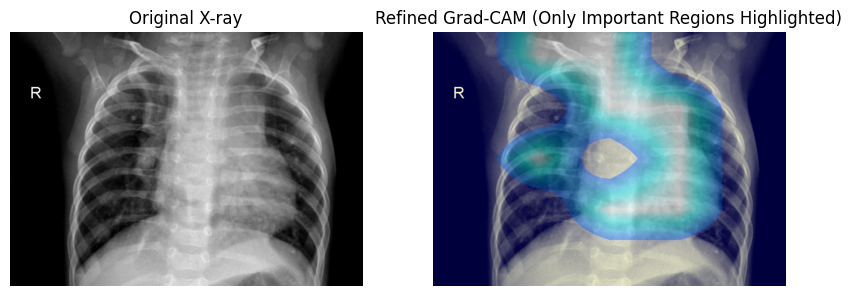

In [ ]:
heatmap = make_gradcam_heatmap(input_tensor, loaded_model, last_conv_layer_name)

# ✅ 중요도가 높은 부분만 남기기 (활성화 필터링 적용)
filtered_heatmap = filter_high_importance(heatmap, threshold=0.5, alpha=3.0, beta=80)

# ✅ 원본 X-ray 이미지 로드
original_img = cv2.imread(test_image1_path)
original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

# ✅ 중요 영역만 강조하고 원본 이미지 유지
final_gradcam = overlay_highlighted_gradcam(original_img, filtered_heatmap, threshold=0.4, alpha=0.4)

# ✅ 결과 시각화
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(original_img)
plt.title("Original X-ray")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(final_gradcam)
plt.title("Refined Grad-CAM (Only Important Regions Highlighted)")
plt.axis("off")

plt.show()

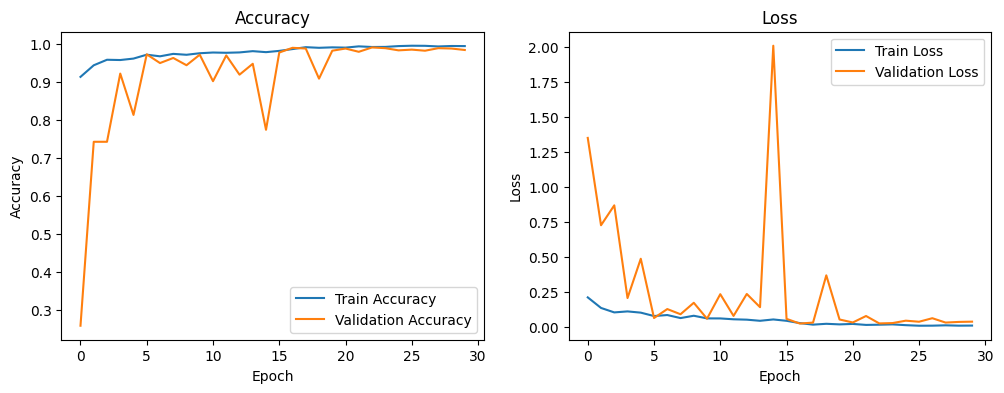

In [ ]:
# Plot accuracy and loss
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 671ms/step
Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.91      0.91      0.91       234
   PNEUMONIA       0.95      0.95      0.95       390

    accuracy                           0.93       624
   macro avg       0.93      0.93      0.93       624
weighted avg       0.93      0.93      0.93       624

Overall Test Accuracy: 0.93
AUC-ROC: 0.98
AUC-PR: 0.99
Confusion Matrix:


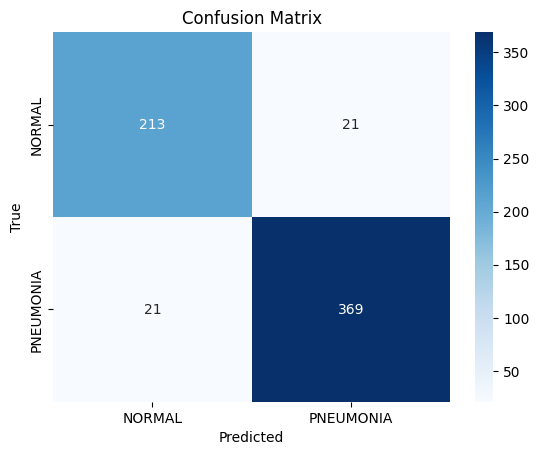

Sensitivity (Recall for PNEUMONIA): 0.95
Specificity (Recall for NORMAL): 0.91


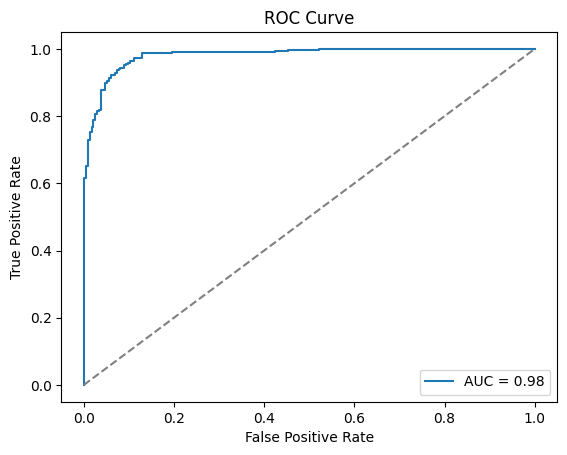

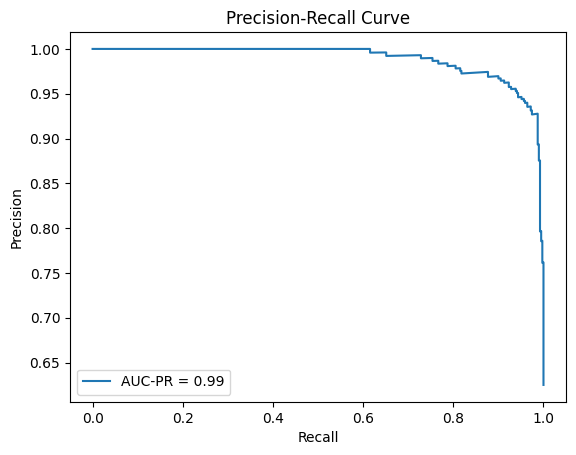

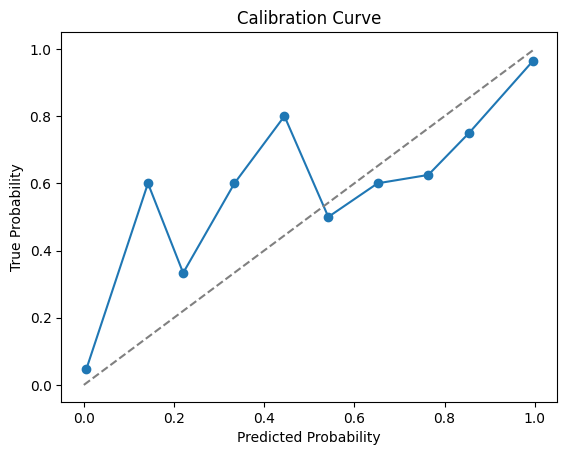

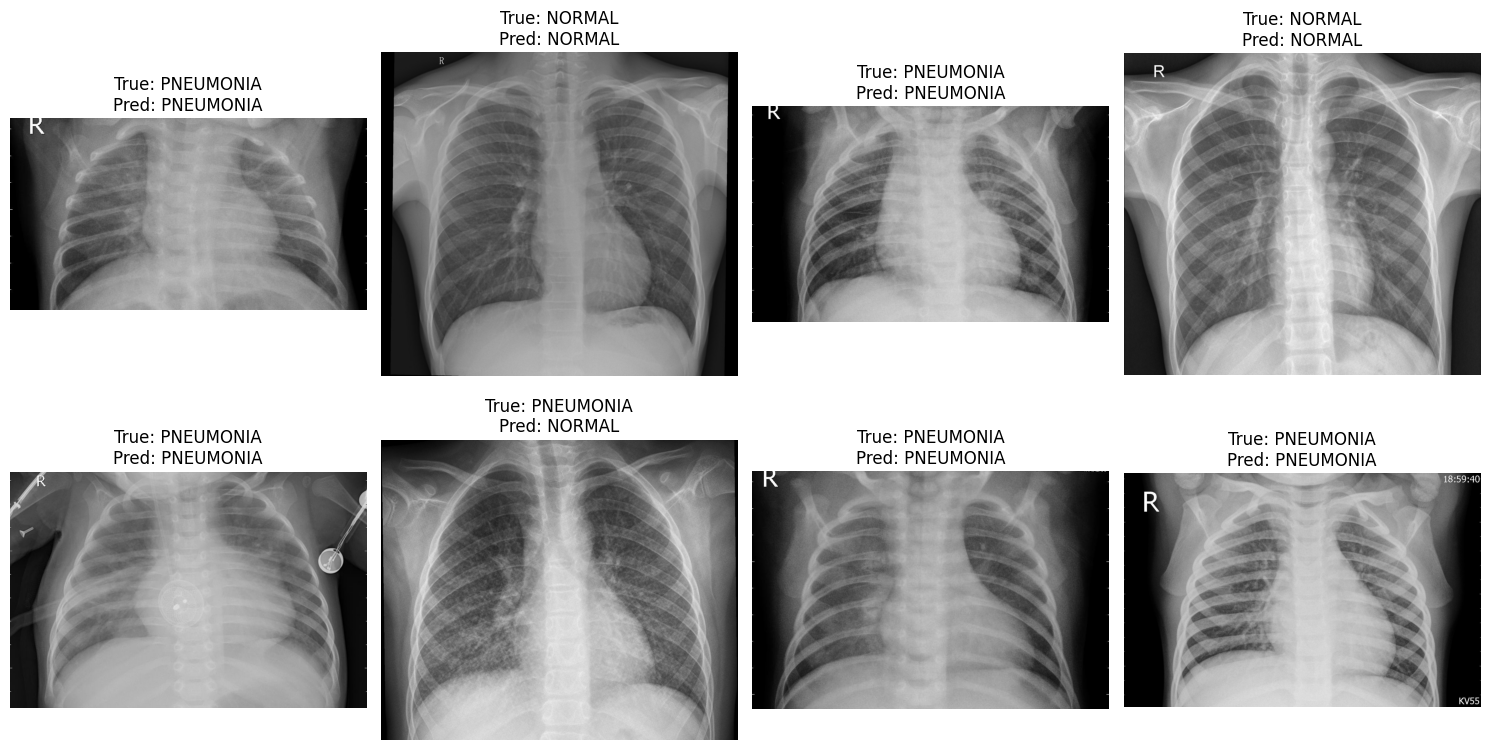

In [ ]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, precision_recall_curve, auc,roc_curve
from sklearn.calibration import calibration_curve
import seaborn as sns

# Enhanced function
def test_and_visualize_with_metrics(model, test_generator):
    # Get predictions and true labels
    predictions = model.predict(test_generator)
    y_true = test_generator.classes  # True labels
    y_pred = (predictions > 0.5).astype(int)  # Predicted labels

    # Class labels
    class_indices = test_generator.class_indices
    class_names = list(class_indices.keys())

    # Classification report
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Overall accuracy
    from sklearn.metrics import accuracy_score
    overall_accuracy = accuracy_score(y_true, y_pred)
    print(f"Overall Test Accuracy: {overall_accuracy:.2f}")

    # AUC-ROC
    auc_roc = roc_auc_score(y_true, predictions)
    print(f"AUC-ROC: {auc_roc:.2f}")

    # AUC-PR
    precision, recall, _ = precision_recall_curve(y_true, predictions)
    auc_pr = auc(recall, precision)
    print(f"AUC-PR: {auc_pr:.2f}")

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:")
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # Sensitivity and Specificity
    TP = cm[1, 1]  # True Positives
    FN = cm[1, 0]  # False Negatives
    FP = cm[0, 1]  # False Positives
    TN = cm[0, 0]  # True Negatives

    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0

    print(f"Sensitivity (Recall for PNEUMONIA): {sensitivity:.2f}")
    print(f"Specificity (Recall for NORMAL): {specificity:.2f}")

    # ROC Curve
    fpr, tpr, thresholds = roc_curve(y_true, predictions)
    plt.plot(fpr, tpr, label=f"AUC = {auc_roc:.2f}")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal for random guessing
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

    # Precision-Recall Curve
    plt.plot(recall, precision, label=f"AUC-PR = {auc_pr:.2f}")
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.show()

    # Calibration Curve
    prob_true, prob_pred = calibration_curve(y_true, predictions, n_bins=10)
    plt.plot(prob_pred, prob_true, marker='o')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Perfect calibration line
    plt.xlabel('Predicted Probability')
    plt.ylabel('True Probability')
    plt.title('Calibration Curve')
    plt.show()

    # Visualize random sample predictions
    visualize_results_with_generator(test_generator, predictions, class_names)

# Visualization function remains the same
def visualize_results_with_generator(test_generator, predictions, class_names):
    # Display a few images with predictions
    filepaths = test_generator.filepaths
    true_labels = test_generator.classes
    predicted_labels = (predictions > 0.5).astype(int)

    # Select a few images for visualization
    sample_indices = np.random.choice(len(filepaths), size=8, replace=False)
    sample_images = [filepaths[i] for i in sample_indices]
    sample_predictions = [predicted_labels[i] for i in sample_indices]
    sample_true_labels = [true_labels[i] for i in sample_indices]

    # Plot images with predictions
    fig, axes = plt.subplots(2, 4, figsize=(15, 8))
    for i, ax in enumerate(axes.flat):
        img = cv2.imread(sample_images[i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        true_label = class_names[sample_true_labels[i]]
        pred_label = class_names[sample_predictions[i][0]]

        ax.imshow(img)
        ax.set_title(f"True: {true_label}\nPred: {pred_label}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Call the enhanced function
test_and_visualize_with_metrics(model, test_generator)

In [323]:
def make_gradcampp_heatmap(img_array, model, last_conv_layer_name="conv5_block3_out", pred_index=None):
    """
    Grad-CAM++ Heatmap을 생성하는 함수 (개선된 버전)
    """
    # 입력 이미지를 4D 텐서로 변환 (배치 차원 추가)
    img_array = tf.convert_to_tensor(img_array, dtype=tf.float32)
    if len(img_array.shape) == 3:
        img_array = tf.expand_dims(img_array, axis=0)

    try:
        last_conv_layer = model.get_layer(last_conv_layer_name).output
    except ValueError:
        raise ValueError(f"❌ '{last_conv_layer_name}' 레이어를 찾을 수 없습니다. 모델 레이어 목록을 확인하세요.")

    grad_model = tf.keras.models.Model(
        inputs=model.input,
        outputs=[last_conv_layer, model.output]
    )

    with tf.GradientTape(persistent=True) as tape:
        tape.watch(img_array)
        conv_outputs, preds = grad_model(img_array)

        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

        # 그래디언트 계산 및 None 체크
        first_grad = tape.gradient(class_channel, conv_outputs)
        if first_grad is None:
            raise ValueError(f"❌ 1차 그래디언트 계산 실패! `{last_conv_layer_name}`이 올바른지, 모델 구조가 적절한지 확인하세요.")

        second_grad = tape.gradient(first_grad, conv_outputs)
        if second_grad is None:
            raise ValueError(f"❌ 2차 그래디언트 계산 실패! `{last_conv_layer_name}`이 올바른지, 모델 구조가 적절한지 확인하세요.")

        third_grad = tape.gradient(second_grad, conv_outputs)
        if third_grad is None:
            raise ValueError(f"❌ 3차 그래디언트 계산 실패! `{last_conv_layer_name}`이 올바른지, 모델 구조가 적절한지 확인하세요.")

    # alpha_denom 계산 개선 (epsilon 추가)
    alpha_num = second_grad
    alpha_denom = 2 * second_grad + tf.reduce_sum(conv_outputs * third_grad, axis=(1, 2), keepdims=True)
    alpha_denom = tf.maximum(alpha_denom, 1e-8)  # epsilon 추가
    alphas = alpha_num / alpha_denom

    conv_outputs = conv_outputs[0].numpy()
    first_grad = first_grad[0].numpy()
    alphas = alphas[0].numpy()

    weights = np.maximum(first_grad, 0.0)
    deep_linearization_weights = np.sum(weights * alphas, axis=(0, 1))
    grad_CAM_map = np.sum(deep_linearization_weights * conv_outputs, axis=-1)

    heatmap = np.maximum(grad_CAM_map, 0)
    max_val = heatmap.max() if heatmap.max() != 0 else 1e-8
    heatmap /= max_val
    heatmap = np.uint8(255 * heatmap)

    return heatmap

def filter_high_importance(heatmap, threshold=0.8, alpha=5.0, beta=80):
    """
    ✅ Grad-CAM Heatmap에서 중요도가 낮은 부분을 제거하고,
       빨간색/노란색을 강조하며 밝기를 조정하는 함수.
       + alpha, beta 값을 조절하여 대비와 밝기를 더욱 세밀하게 조정
       + cv2.COLORMAP_TURBO 사용으로 빨간색과 노란색 계열 강조
    """
    heatmap = heatmap.astype(np.float32) / 255.0

    # ✅ Threshold 이하의 값 제거 (활성도가 약한 영역 제거)
    heatmap[heatmap < threshold] = 0.0

    # ✅ 남은 영역을 0~1로 다시 정규화하여 강조 (최대값으로 나누기)
    if heatmap.max() > 0:  # 0으로 나누는 에러 방지
        heatmap = heatmap / heatmap.max()

    heatmap = (heatmap * 255).astype(np.uint8)

    # ✅ 밝기 조정 (alpha=대비 증가, beta=밝기 증가)
    #   - alpha 값을 높이면 대비가 강해져 활성화된 영역이 더 뚜렷해짐
    #   - beta 값을 높이면 전반적인 밝기가 증가
    heatmap = cv2.convertScaleAbs(heatmap, alpha=alpha, beta=beta)

    # ✅ 컬러맵 적용 (빨간색/노란색 강조)
    filtered_heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_HOT)

    return filtered_heatmap

def overlay_highlighted_gradcam(original_img, heatmap, threshold=0.7, alpha=0.6):
    """
    ✅ 중요도가 높은 부분만 강조하고 원본 이미지는 유지하는 Grad-CAM++ Overlay
    ✅ 너무 희미한 Heatmap 문제 해결 → threshold 증가 및 대비 강화
    ✅ `COLORMAP_HOT` 사용하여 빨간색/노란색 강조
    """
    heatmap = cv2.resize(heatmap, (original_img.shape[1], original_img.shape[0]), interpolation=cv2.INTER_LINEAR)

    # ✅ 특정 Threshold 이하의 값 제거
    heatmap = heatmap.astype(np.float32) / 255.0
    heatmap[heatmap < threshold] = 0.0  # 약한 활성화 제거

    # ✅ Heatmap이 0이면 오류 방지
    heatmap_max = heatmap.max()
    heatmap = (heatmap / heatmap_max) if heatmap_max > 0 else np.zeros_like(heatmap)
    heatmap = np.uint8(255 * heatmap)

    # ✅ 컬러맵 적용 (빨간색/노란색 강조)
    colored_heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_HOT)

    # ✅ 활성화된 영역만 원본 이미지 위에 Overlay
    mask = (heatmap > (threshold * 255)).astype(np.uint8)
    highlighted_img = original_img.copy()
    highlighted_img[mask > 0] = cv2.addWeighted(
        highlighted_img.astype(np.uint8), 1 - alpha, colored_heatmap, alpha, 0
    )[mask > 0]

    return highlighted_img

In [328]:
# Define test image directory (PNEUMONIA folder)
test_pneumonia_dir = Path('/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/test/PNEUMONIA')

# Verify if directory exists
if not test_pneumonia_dir.exists():
    raise ValueError(f"❌ ERROR: Test image folder not found at {test_pneumonia_dir}")

# Get a list of all images in the folder (JPEG, JPG, PNG)
image_files = list(test_pneumonia_dir.glob("*.jpeg")) + list(test_pneumonia_dir.glob("*.jpg")) + list(test_pneumonia_dir.glob("*.png"))

# Check if there are any images
if not image_files:
    raise ValueError(f"❌ ERROR: No images found in {test_pneumonia_dir}")

# Select the first image
test_image1_path = str(image_files[25])
print(f"Using test image: {test_image1_path}")
# Load the selected image

original_img = cv2.imread(test_image1_path)

# Ensure OpenCV successfully loads the image
if original_img is None:
    raise ValueError(f"❌ ERROR: Could not load image at {test_image1_path}. Check if the file exists!")

# Convert BGR to RGB (Matplotlib expects RGB)
original_img_rgb = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

# Resize image to model input size (150x150)
resized_img = cv2.resize(original_img_rgb, (150, 150))

# Prepare for model input (Normalize & Add batch dimension)
input_tensor = np.expand_dims(resized_img, axis=0) / 255.0

Using test image: /root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/test/PNEUMONIA/person103_bacteria_490.jpeg


In [326]:
heatmap = make_gradcampp_heatmap(input_tensor, loaded_model, last_conv_layer_name="conv4_block6_out")

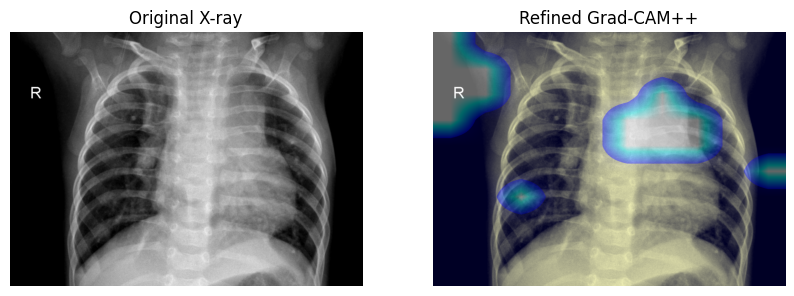

In [329]:
# ✅ 중요도가 높은 부분만 남기기 (활성화 필터링 적용)
filtered_heatmap = filter_high_importance(heatmap, threshold=0.7, alpha=3.0, beta=50)

# ✅ 원본 X-ray 이미지 로드
original_img = cv2.imread(test_image1_path)
original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

# ✅ 원본 X-ray 이미지 로드
original_img = cv2.imread(test_image1_path)
original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

# ✅ 중요 영역만 강조하고 원본 이미지 유지
final_gradcam = overlay_highlighted_gradcam(original_img, filtered_heatmap, threshold=.3, alpha=0.4)

# ✅ 결과 시각화
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(original_img)
plt.title("Original X-ray")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(final_gradcam)
plt.title("Refined Grad-CAM++")
plt.axis("off")

plt.show()

Using test image: /root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/test/PNEUMONIA/person150_bacteria_716.jpeg


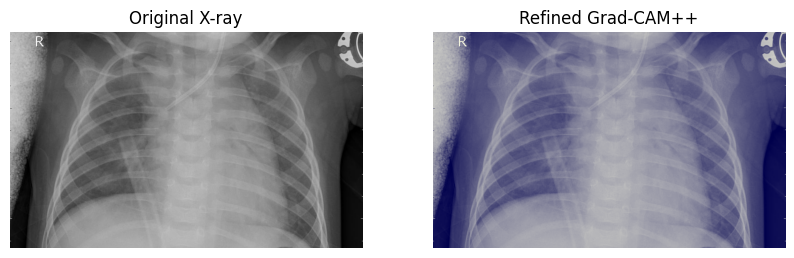

Using test image: /root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/test/PNEUMONIA/person157_bacteria_740.jpeg


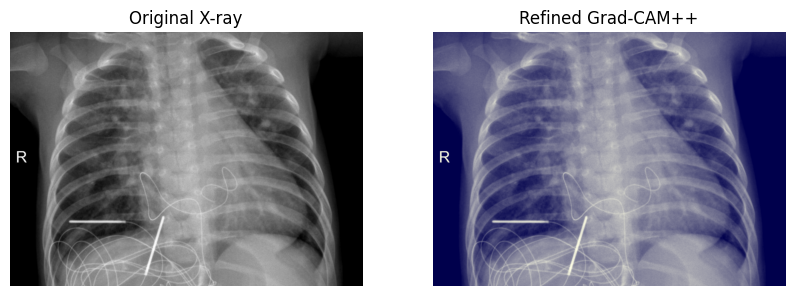

Using test image: /root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/test/PNEUMONIA/person1668_virus_2882.jpeg


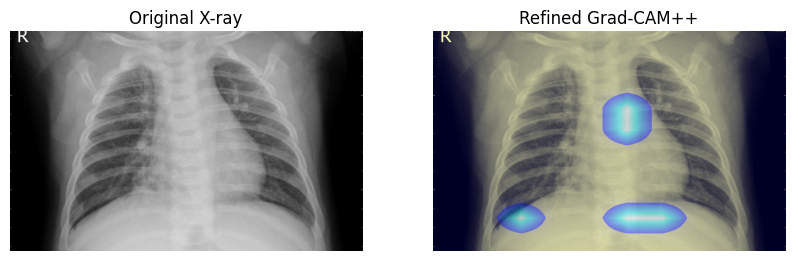

Using test image: /root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/test/PNEUMONIA/person1627_virus_2819.jpeg


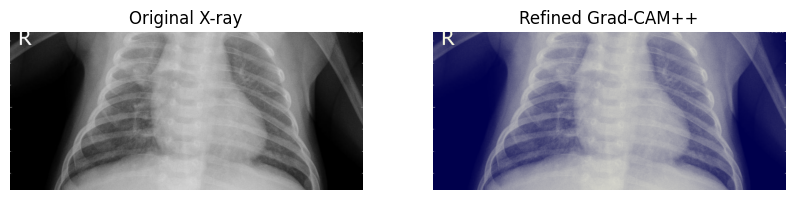

Using test image: /root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/test/PNEUMONIA/person53_virus_108.jpeg


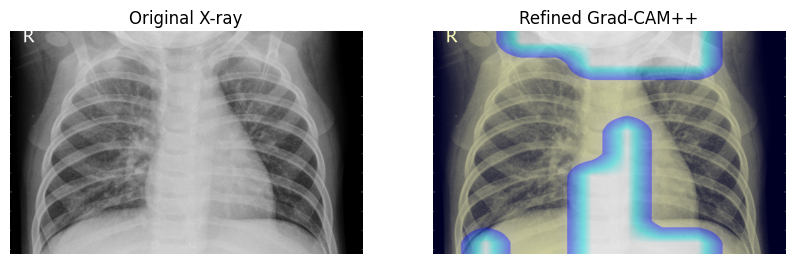

Using test image: /root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/test/PNEUMONIA/person118_bacteria_559.jpeg


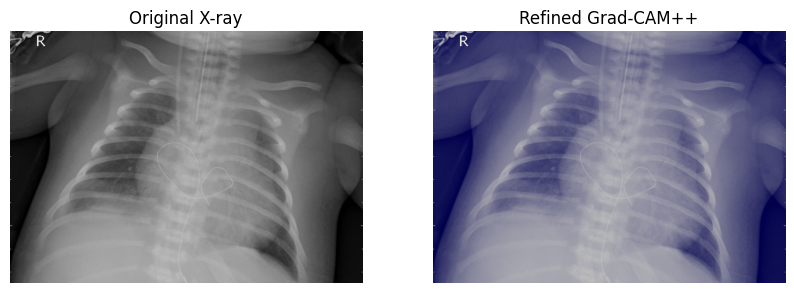

Using test image: /root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/test/PNEUMONIA/person69_virus_129.jpeg


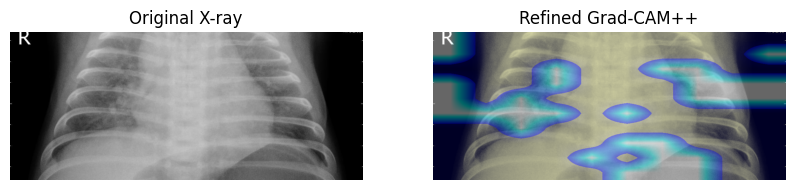

Using test image: /root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/test/PNEUMONIA/person1667_virus_2881.jpeg


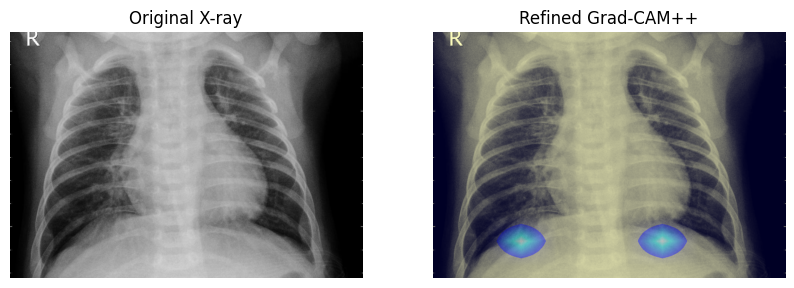

Using test image: /root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/test/PNEUMONIA/person89_bacteria_440.jpeg


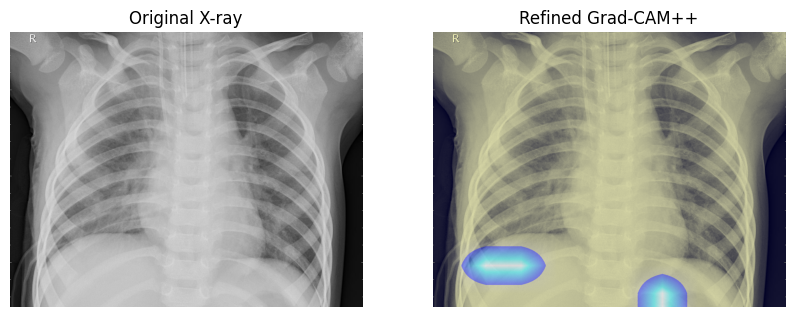

Using test image: /root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/test/PNEUMONIA/person122_bacteria_583.jpeg


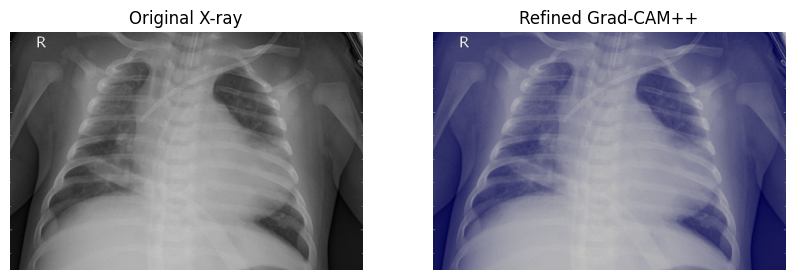

In [333]:
for image_file in image_files[35:45]:  # 16번째부터 20번째까지 5개의 이미지 테스트
    test_image1_path = str(image_file)
    print(f"Using test image: {test_image1_path}")

    # Load the selected image
    original_img = cv2.imread(test_image1_path)
    if original_img is None:
        print(f"❌ ERROR: Could not load image at {test_image1_path}. Skipping.")
        continue  # 이미지 로드 실패 시 다음 이미지로 넘어감

    # Convert BGR to RGB (Matplotlib expects RGB)
    original_img_rgb = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

    # Resize image to model input size
    input_shape = (150, 150)
    resized_img = cv2.resize(original_img_rgb, input_shape)

    # Prepare for model input (Normalize & Add batch dimension)
    input_tensor = np.expand_dims(resized_img, axis=0) / 255.0

    # ✅ NumPy 배열을 Tensor로 변환
    input_tensor = tf.convert_to_tensor(input_tensor, dtype=tf.float32)

    # ✅ 기존 Grad-CAM++ Heatmap 생성
    heatmap = make_gradcampp_heatmap(input_tensor, loaded_model, last_conv_layer_name="conv4_block6_out")

    # ✅ 중요도가 높은 부분만 남기기 (활성화 필터링 적용)
    filtered_heatmap = filter_high_importance(heatmap, threshold=0.7, alpha=3.0, beta=50)

    # ✅ 중요 영역만 강조하고 원본 이미지 유지
    final_gradcam = overlay_highlighted_gradcam(original_img_rgb, filtered_heatmap, threshold=0.3, alpha=0.4)

    # ✅ 결과 시각화
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(original_img_rgb)
    plt.title("Original X-ray")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(final_gradcam)
    plt.title("Refined Grad-CAM++")
    plt.axis("off")

    plt.show()

NotFoundError: {{function_node __wrapped__PrintV2_device_/job:localhost/replica:0/task:0/device:CPU:0}} /dev/stdout; No such device or address [Op:PrintV2] name: 